In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.colors as mcolors
import seaborn as sns
import math

# import warnings
# warnings.filterwarnings('ignore')

from datetime import timedelta

In [2]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils

# Load FastF1's dark color scheme
ff1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,
                          color_scheme='fastf1')

In [3]:
# Enable the cache by providing the name of your cache folder
cache_path = '/Users/charlotte/Desktop/mclaren-performance-analysis-2024/cache'
ff1.Cache.enable_cache(cache_path)

In [4]:
# Define target session
year, grand_prix, session = 2024, 'Miami', 'Q'

# Load target session
target_session = ff1.get_session(year, grand_prix, session)
target_session.load(telemetry=True)

# Define target drivers
driver_1, driver_2 = 'NOR', 'VER'
team_1, team_2, team_3 = 'McLaren', 'Ferrari', 'Red Bull Racing'

core           INFO 	Loading data for Miami Grand Prix - Qualifying [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '4', '81', '63', '44', '27', '22', '18', '10', '31', '23', '14', '77', '2', '3', '20', '24']


In [5]:
# Function to lighten team colour
def lighten_color(color, amount=0.5):
    color = mcolors.to_rgb(color)
    return [(1 - amount) * c + amount for c in color]

# Retrieve team colors from target_session.results based on driver abbreviations
team_color_1 = '#' + target_session.results[target_session.results['Abbreviation'] == driver_1].iloc[0]['TeamColor']
team_color_2 = '#' + target_session.results[target_session.results['Abbreviation'] == driver_2].iloc[0]['TeamColor']

# If drivers for analysis are from the same team then adjust driver_2 colour
if team_color_1 == team_color_2:
    # Lighten one color for distinction or use a dashed line
    from matplotlib.colors import to_rgb
    team_color_2 = lighten_color(team_color_2, amount=0.6)
    linestyle_2 = '--'

In [6]:
telemetry = target_session.laps.loc[0].get_car_data().add_distance()
telemetry.head()

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance
0,2024-05-04 20:05:46.231,6883,80,2,32,False,8,car,0 days 00:00:00.276000,0 days 00:18:48.219000,6.133333
1,2024-05-04 20:05:46.511,7375,83,2,29,False,8,car,0 days 00:00:00.556000,0 days 00:18:48.499000,12.588889
2,2024-05-04 20:05:46.671,7838,88,2,31,False,8,car,0 days 00:00:00.716000,0 days 00:18:48.659000,16.500000
3,2024-05-04 20:05:46.831,8077,90,2,32,False,8,car,0 days 00:00:00.876000,0 days 00:18:48.819000,20.500000
4,2024-05-04 20:05:47.071,8524,96,2,37,False,8,car,0 days 00:00:01.116000,0 days 00:18:49.059000,26.900000


In [7]:
# Access selected driver fastest laps
laps_driver_1 = target_session.laps.pick_drivers(driver_1).pick_fastest()
laps_driver_2 = target_session.laps.pick_drivers(driver_2).pick_fastest()

# Retrieve the telemetry and add the distance column
telemetry_driver_1 = laps_driver_1.get_car_data().add_distance()
telemetry_driver_2 = laps_driver_2.get_car_data().add_distance()

In [ ]:
# Identify session type analysed for title in more legible way
session_types = {
    'Q': 'Qualifying',
    'R': 'Grand Prix',
    'Practice 1': 'FP1',
    'Practice 2': 'FP2',
    'Practice 3': 'FP3'
}

session_type = session_types.get(session, 'Unknown Session')

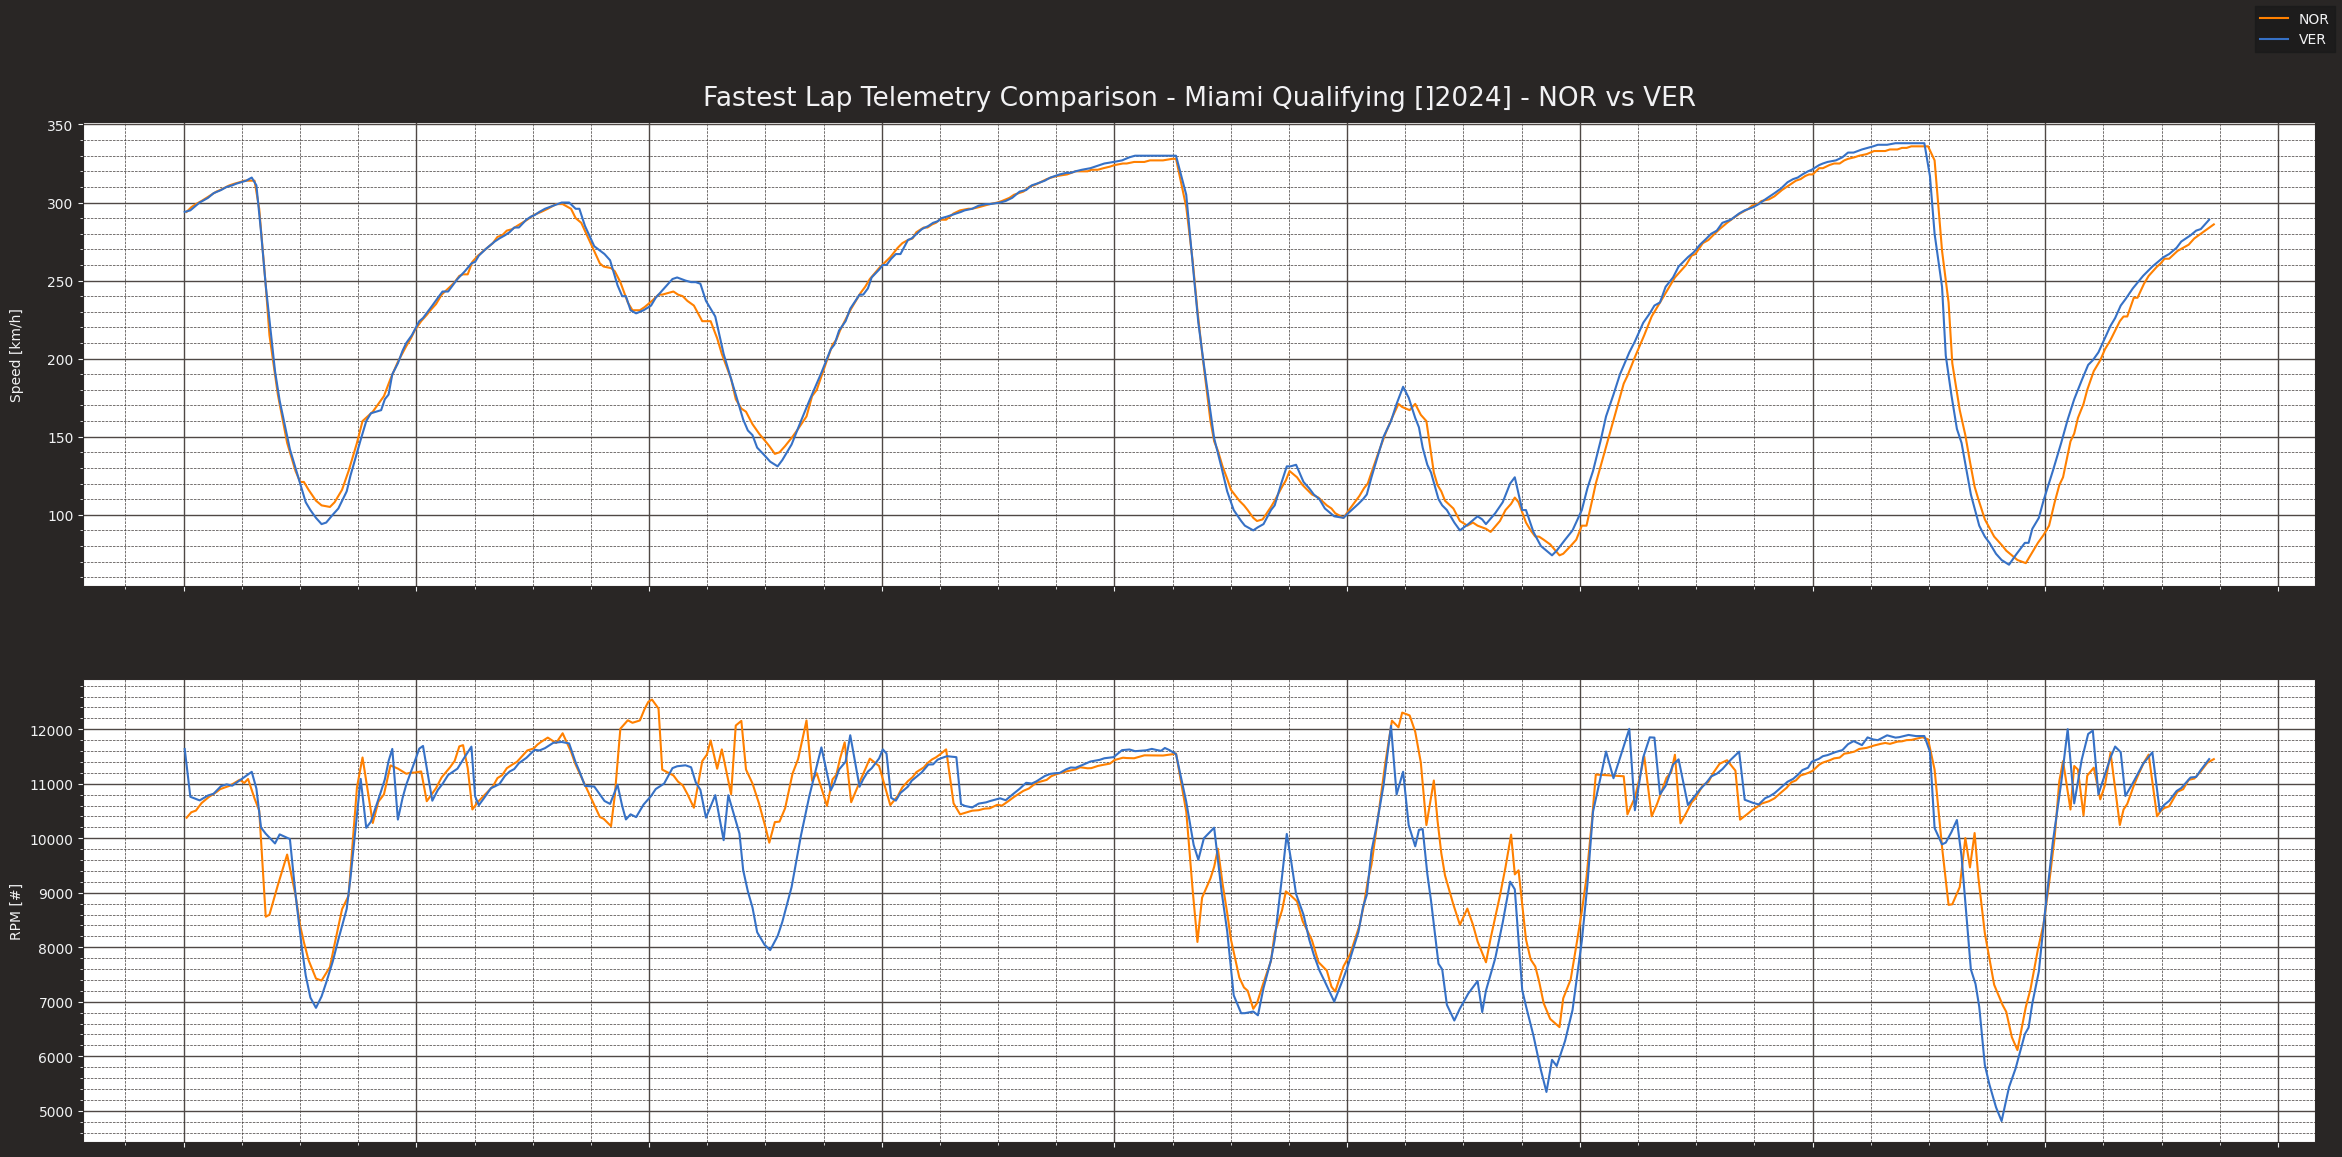

In [10]:
# Plot Telemetry
plotting.setup_mpl(color_scheme='fastf1')

subplots_number = 2 # Adjust to match number of plots included
fig, ax = plt.subplots(subplots_number,figsize=(24,12))

background = "white"
title_color = 'silver' # '#6441a5'

ax[0].set_facecolor(background)
ax[1].set_facecolor(background)
# ax[2].set_facecolor(background)
# ax[3].set_facecolor(background)
# ax[4].set_facecolor(background)
# ax[5].set_facecolor(background)


ax[0].plot(telemetry_driver_1['Time'], telemetry_driver_1['Speed'], color=team_color_1, linestyle='-', label=driver_1)
ax[0].plot(telemetry_driver_2['Time'], telemetry_driver_2['Speed'], color=team_color_2, linestyle='-', label=driver_2)

ax[1].plot(telemetry_driver_1['Time'], telemetry_driver_1['RPM'], color=team_color_1, linestyle='-', label=driver_1)
ax[1].plot(telemetry_driver_2['Time'], telemetry_driver_2['RPM'], color=team_color_2, linestyle='-', label=driver_2)

# ax[2].plot(telemetry_driver_1['Time'], telemetry_driver_1['nGear'], color=team_color_1, linestyle='-', label=driver_1)
# ax[2].plot(telemetry_driver_2['Time'], telemetry_driver_2['nGear'], color=team_color_2, linestyle='-', label=driver_2)

# ax[3].plot(telemetry_driver_1['Time'], telemetry_driver_1['Throttle'], color=team_color_1, linestyle='-', label=driver_1)
# ax[3].plot(telemetry_driver_2['Time'], telemetry_driver_2['Throttle'], color=team_color_2, linestyle='-', label=driver_2)

# ax[4].plot(telemetry_driver_1['Time'], telemetry_driver_1['Brake'], color=team_color_1, linestyle='-', label=driver_1)
# ax[4].plot(telemetry_driver_2['Time'], telemetry_driver_2['Brake'], color=team_color_2, linestyle='-', label=driver_2)

# ax[5].plot(telemetry_driver_1['Time'], telemetry_driver_1['DRS'], color=team_color_1, linestyle='-', label=driver_1)
# ax[5].plot(telemetry_driver_2['Time'], telemetry_driver_2['DRS'], color=team_color_2, linestyle='-', label=driver_2)

ax[0].set_ylabel("Speed [km/h]")
ax[1].set_ylabel("RPM [#]")
# ax[2].set_ylabel("Gear [#]")
# ax[3].set_ylabel("Throttle [%]")
# ax[4].set_ylabel("Brake [%]")
# ax[5].set_ylabel("DRS")

ax[0].get_xaxis().set_ticklabels([])
ax[1].get_xaxis().set_ticklabels([])
# ax[2].get_xaxis().set_ticklabels([])
# ax[3].get_xaxis().set_ticklabels([])
# ax[4].get_xaxis().set_ticklabels([])
# ax[5].get_xaxis().set_ticklabels([])

fig.align_ylabels()

fig.legend([driver_1,driver_2])


plot_title = 'Fastest Lap Telemetry Comparison - '+grand_prix+' '+session_type+' []'+str(year)+'] - '+driver_1+' vs '+driver_2
ax[0].title.set_text(plot_title)
plt.subplots_adjust(left=0.06 ,right=0.99, top=0.9, bottom=0.05)

# Uncomment to save plot
# plt.savefig(plot_title+'.png', dpi=300)